In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Dense, LSTM, Subtract
from tensorflow.keras.models import Model
from Environment import *
from tqdm import tqdm
import matplotlib.pyplot as plt
from copy import deepcopy

In [2]:
dense_1_user =  Dense(32, activation = 'relu')
dense_2_user =  Dense(32, activation = 'relu')
# dense_3_user =  Dense(32, activation = 'relu')

dense_1_assist =  Dense(32, activation = 'relu')
lstm_1_assist = LSTM(32, activation = 'relu')
# dense_2_assist = Dense(32, activation = 'relu')

# advantage_layer_user = Dense(4)
# value_layer_user = Dense(1)

# advantage_layer_assist = Dense(4)
# value_layer_assist = Dense(1)

advantage_layer = Dense(4)
value_layer = Dense(1)

In [3]:
class AI_Design:
    def __init__(self, steps = 4):        
        self.loss_fn = tf.keras.losses.mean_squared_error
        self.optimizer = tf.keras.optimizers.Adam(lr = 0.0001)
        self.batch_size = 1024
        self.replay_buffer_size = 10240
        self.replay_buffer = Replay_Buffer(self.replay_buffer_size)
        self.epsilon = 0.75
        self.gamma = 0.9
        self.env = Environment()
        self.env.cells = np.array([[0.7, 0.1], [0.1, 0.1], [0.5, 0.7], [0.6, 0.2], [0.7, 0.4], [0.2, 0.9]])
        
        #-------------------------------------------------------------------------------------------------
        input_A = Input(shape = (4,))
        input_B = Input(shape = (steps,6))
        action_user = Input(shape = 1, dtype = tf.int32)
        action_assist = Input(shape = 1, dtype = tf.int32)
        
        x = Subtract()([input_A[:, 2:], input_A[:, :2]])
        x = dense_1_user(x)
        x = dense_2_user(x)
#         x = dense_3_user(x)
        adv_user = advantage_layer(x)
        val_user = value_layer(x)
        output_user = adv_user - tf.reduce_mean(adv_user, axis = 1, keepdims = True) + val_user
        
        self.user_model = Model(inputs = input_A, outputs = output_user)
        self.user_model.summary()
        
        self.target_user_model = tf.keras.models.clone_model(self.user_model)
        self.target_user_model.set_weights(self.user_model.get_weights())
        

        
        y = dense_1_assist(input_B)
        y = lstm_1_assist(y)
#         y = dense_2_assist(y)
        adv_assist = advantage_layer(y)
        val_assist = value_layer(y)
        output_assist = adv_assist - tf.reduce_mean(adv_assist, axis = 1, keepdims = True) + val_assist
        
        self.assist_model = Model(inputs = input_B, outputs = output_assist)
        self.assist_model.summary()
        
        self.target_assist_model = tf.keras.models.clone_model(self.assist_model)
        self.target_assist_model.set_weights(self.assist_model.get_weights())
        
        mask_user = tf.reduce_sum(tf.one_hot(action_user, 4), axis = 1)
        mask_assist = tf.reduce_sum(tf.one_hot(action_assist, 4), axis = 1)
        output_user = output_user*mask_user
        output_assist = output_assist*mask_assist
        
        out = tf.reduce_sum(output_user + output_assist, axis = 1, keepdims = True)
        
        self.model = Model(inputs = [input_A, input_B, action_user, action_assist], outputs = out)  
        self.model.summary() 
        #-------------------------------------------------------------------------------------------------
    
    def infer(self):
        ob_user, action_user, reward_user, next_ob_user, ob_assist, action_assist,\
        reward_assist, next_ob_assist, done = self.sample_exp()
        
        ob_user = ob_user[1:4]
        action_user = action_user[1:4]
        reward_user = reward_user[1:4]
        
        ob_assist = ob_assist[1:4]
        action_assist = action_assist[1:4]
        reward_assist = reward_assist[1:4]
        
        print(action_user, action_assist)
        
        print(self.user_model(ob_user))
        print(self.assist_model(ob_assist))
        
        print(self.model([ob_user, ob_assist, action_user, action_assist]))
    
    def exp_policy_user(self, state):
        if np.random.rand()<self.epsilon:
            return np.random.randint(4)
        else:
            state = np.array(state)[np.newaxis]
            Q_values = self.user_model(state)
            return np.argmax(Q_values[0])
    
    def exp_policy_assist(self, state):
        if np.random.rand()<self.epsilon:
            return np.random.randint(1,5)
        else:
            state = np.array(state)[np.newaxis]
            Q_values = self.assist_model(state)
            return np.argmax(Q_values[0])+1
    
    def step(self, ob_user, prev_steps_assist):
        curr_loc = ob_user[:2]
        target_loc = ob_user[2:4]
        
        action_user = self.exp_policy_user(ob_user)
        action_user_one_hot = make_one_hot(action_user, 4)
        
        ob_assist = [action_user_one_hot + ob_user[:2]]
        ob_assist = ob_assist + prev_steps_assist
        action_assist = self.exp_policy_assist(ob_assist)
        
        new_loc, reward_user, reward_assist, done = self.env.step(action_user, action_assist-1, target_loc, curr_loc)
        
        next_ob_user = new_loc[:]
        next_ob_user = next_ob_user + target_loc
        
        next_action_user = self.exp_policy_user(next_ob_user)
        next_action_user_one_hot = make_one_hot(next_action_user, 4)
        next_ob_assist = [next_action_user_one_hot + next_ob_user[:2]]
        next_ob_assist = next_ob_assist + ob_assist[:-1]
        
        self.add_replay_buffer(ob_user, action_user, reward_user, next_ob_user, ob_assist,\
                          action_assist, reward_assist, next_ob_assist, done)
        
        return next_ob_user, ob_assist[:-1], reward_user, reward_assist, done 
        
        
    
    def add_replay_buffer(self, ob_user, action_user, reward_user, next_ob_user, ob_assist,\
                         action_assist, reward_assist, next_ob_assist, done):
        
        self.replay_buffer.ob_user_history.append(ob_user)
        self.replay_buffer.action_user_history.append(action_user)
        self.replay_buffer.reward_user_history.append(reward_user)
        self.replay_buffer.next_ob_user_history.append(next_ob_user)
        self.replay_buffer.ob_assist_history.append(ob_assist)
        self.replay_buffer.action_assist_history.append(action_assist)
        self.replay_buffer.reward_assist_history.append(reward_assist)
        self.replay_buffer.next_ob_assist_history.append(next_ob_assist)
        self.replay_buffer.done_history.append(done)
    
    def sample_exp(self):
        indices = np.random.randint(len(self.replay_buffer.done_history), size = self.batch_size)
        
        ob_user = np.array([self.replay_buffer.ob_user_history[i] for i in indices])
        action_user = np.array([self.replay_buffer.action_user_history[i] for i in indices])
        reward_user = np.array([self.replay_buffer.reward_user_history[i] for i in indices])
        next_ob_user = np.array([self.replay_buffer.next_ob_user_history[i] for i in indices])
        ob_assist = np.array([self.replay_buffer.ob_assist_history[i] for i in indices])
        action_assist = np.array([self.replay_buffer.action_assist_history[i] for i in indices])
        reward_assist = np.array([self.replay_buffer.reward_assist_history[i] for i in indices])
        next_ob_assist = np.array([self.replay_buffer.next_ob_assist_history[i] for i in indices])
        done = np.array([self.replay_buffer.done_history[i] for i in indices])
        
        return ob_user, action_user, reward_user, next_ob_user, ob_assist, action_assist, reward_assist, next_ob_assist, done 
    
    def train(self):
        ob_user, action_user, reward_user, next_ob_user, ob_assist, action_assist,\
        reward_assist, next_ob_assist, done = self.sample_exp()
        
        input_A = ob_user
        input_B = ob_assist
        
        rewards = reward_user + reward_assist
        
        next_Q_values_user, next_Q_values_assist = self.user_model(next_ob_user), self.assist_model(next_ob_assist)
        best_next_actions_user, best_next_actions_assist = tf.math.argmax(next_Q_values_user, axis = 1), tf.math.argmax(next_Q_values_assist, axis = 1)
        next_Q_values_user, next_Q_values_assist = self.target_user_model(next_ob_user), self.target_assist_model(next_ob_assist)
        
        best_next_Q_values_user = tf.reduce_sum(next_Q_values_user*tf.one_hot(best_next_actions_user, 4), axis = 1)
        best_next_Q_values_assist = tf.reduce_sum(next_Q_values_user*tf.one_hot(best_next_actions_assist, 4), axis = 1)
        best_next_Q_values = best_next_Q_values_user + best_next_Q_values_assist
        
        target_Q_values = rewards + (1-done)*self.gamma*best_next_Q_values
        
        with tf.GradientTape() as tape:
            Q_values = self.model([input_A, input_B, action_user, action_assist])
            loss = tf.reduce_mean(self.loss_fn(target_Q_values, Q_values))

        grads = tape.gradient(loss, self.model.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.model.trainable_variables))

In [4]:
steps = 4
model = AI_Design(steps)
env = model.env

Icon Locations:
[[0.2 0.3]
 [0.  0.8]
 [0.7 0.3]
 [0.2 0.1]
 [0.3 0.9]
 [0.8 0.5]]
Icon usage Probabilities
[0.16666667 0.16666667 0.16666667 0.16666667 0.16666667 0.16666667]
Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 4)]          0                                            
__________________________________________________________________________________________________
tf_op_layer_strided_slice (Tens [(None, 2)]          0           input_1[0][0]                    
__________________________________________________________________________________________________
tf_op_layer_strided_slice_1 (Te [(None, 2)]          0           input_1[0][0]                    
__________________________________________________________________________________________________
subtract (

In [5]:
def give_prev_steps(prev_steps_assist, steps):
    prev_steps_assist = [[0,0,0,0,-1,-1] for i in range(steps-1)]
    return prev_steps_assist

  0%|                                                                           | 101/100000 [00:20<7:27:56,  3.72it/s]

16
Saved Weights


  0%|▍                                                                          | 500/100000 [01:52<6:15:11,  4.42it/s]

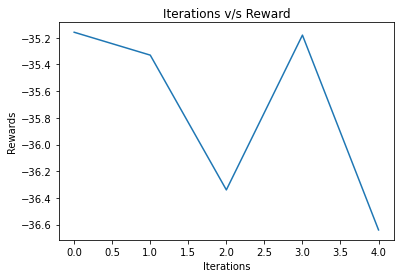

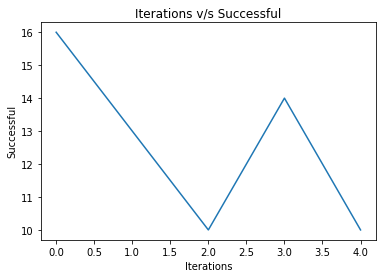

  1%|▌                                                                          | 801/100000 [03:02<6:08:01,  4.49it/s]

19
Saved Weights


  1%|▋                                                                         | 1000/100000 [03:49<6:24:50,  4.29it/s]

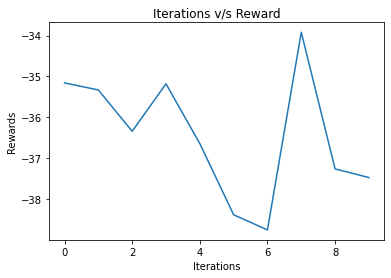

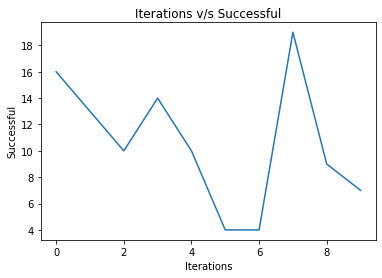

  2%|█                                                                         | 1500/100000 [05:42<5:50:52,  4.68it/s]

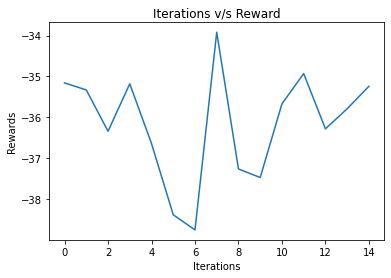

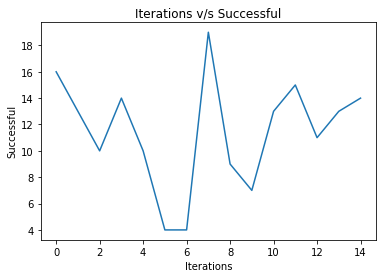

  2%|█▍                                                                        | 2000/100000 [07:36<5:56:03,  4.59it/s]

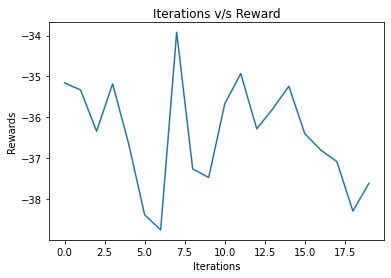

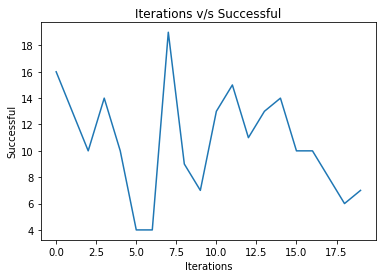

  2%|█▊                                                                        | 2500/100000 [09:28<6:18:07,  4.30it/s]

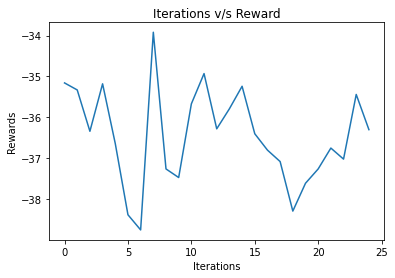

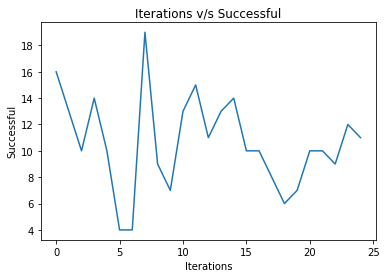

  3%|██▏                                                                       | 3000/100000 [11:35<6:54:23,  3.90it/s]

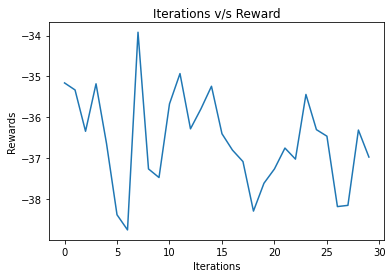

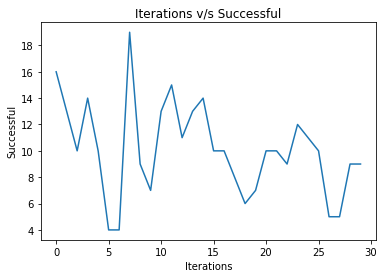

  4%|██▌                                                                       | 3500/100000 [13:39<7:08:58,  3.75it/s]

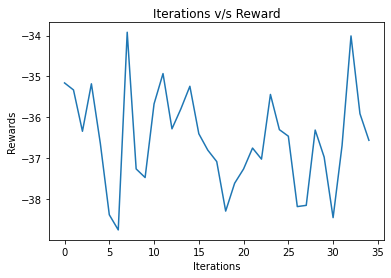

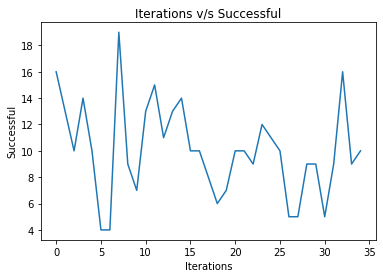

  4%|██▉                                                                       | 4000/100000 [15:45<6:37:24,  4.03it/s]

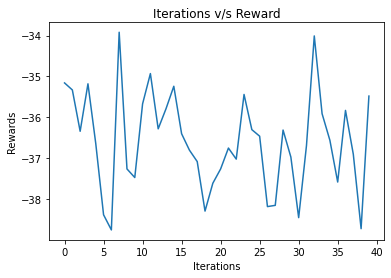

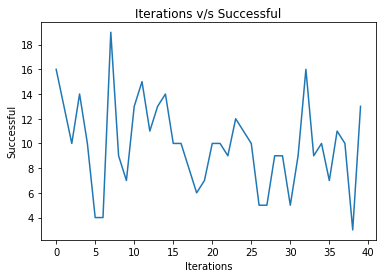

  4%|███▎                                                                      | 4500/100000 [17:51<6:00:47,  4.41it/s]

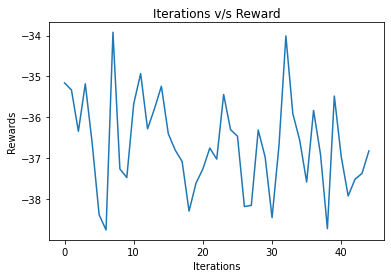

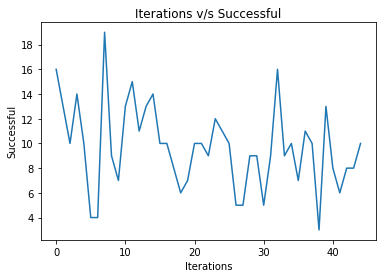

  5%|███▋                                                                      | 5000/100000 [19:53<6:53:38,  3.83it/s]

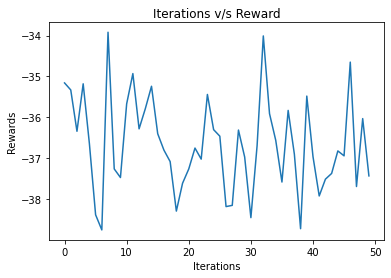

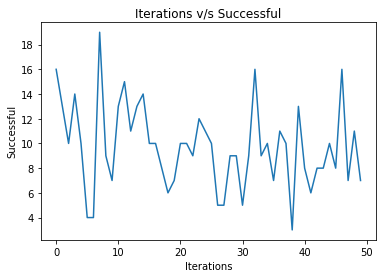

  6%|████                                                                      | 5500/100000 [22:10<7:11:17,  3.65it/s]

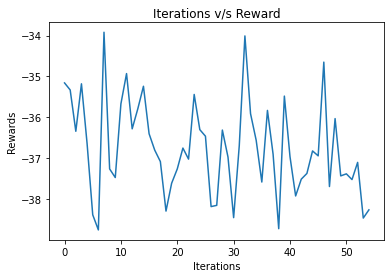

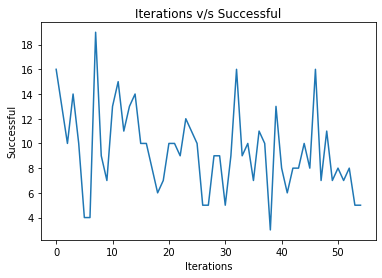

  6%|████▍                                                                     | 6000/100000 [24:29<7:20:53,  3.55it/s]

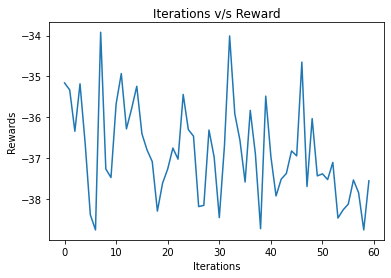

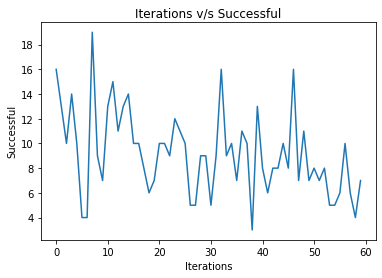

  6%|████▊                                                                     | 6500/100000 [26:47<7:13:11,  3.60it/s]

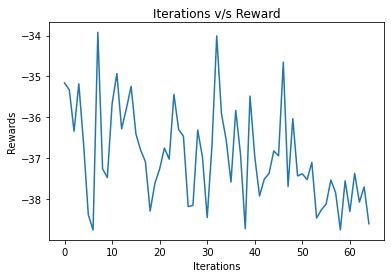

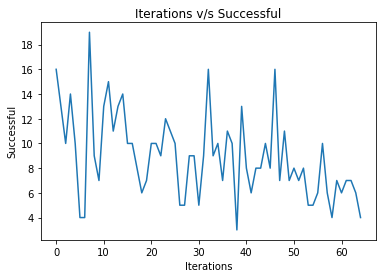

  7%|█████▏                                                                    | 7000/100000 [29:01<6:44:22,  3.83it/s]

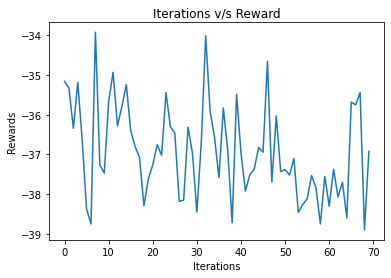

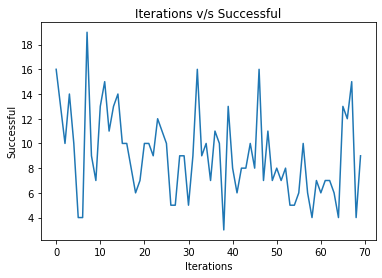

  8%|█████▌                                                                    | 7500/100000 [31:19<6:42:01,  3.83it/s]

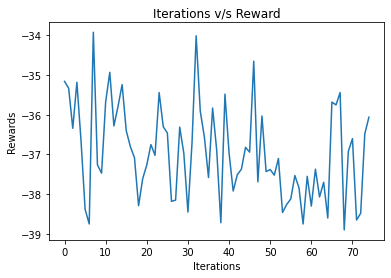

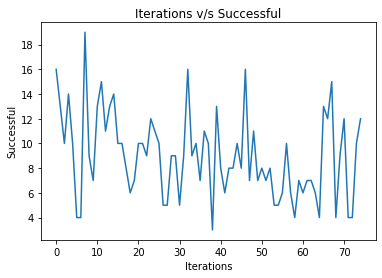

  8%|█████▉                                                                    | 8000/100000 [33:46<8:22:10,  3.05it/s]

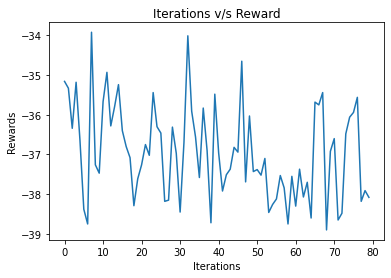

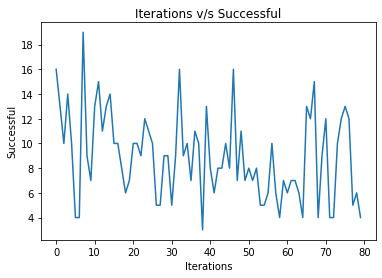

  8%|██████▎                                                                   | 8500/100000 [36:14<7:59:15,  3.18it/s]

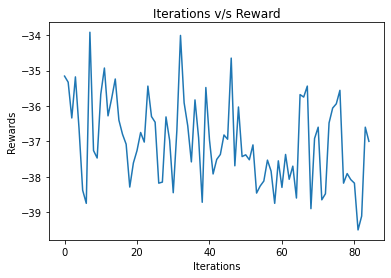

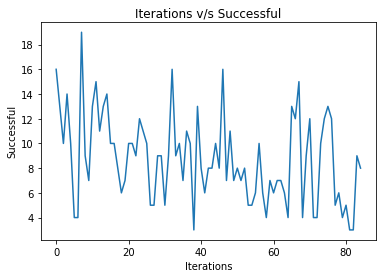

  9%|██████▋                                                                   | 9000/100000 [38:41<7:32:09,  3.35it/s]

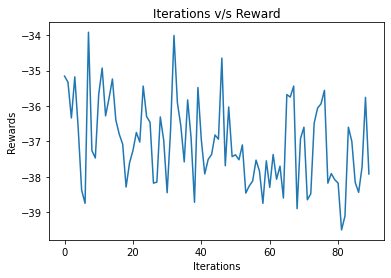

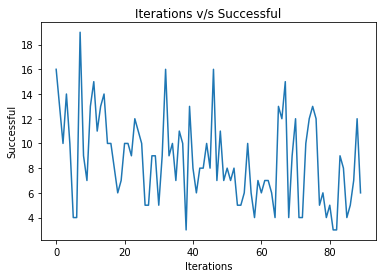

 10%|███████                                                                   | 9500/100000 [41:06<7:35:46,  3.31it/s]

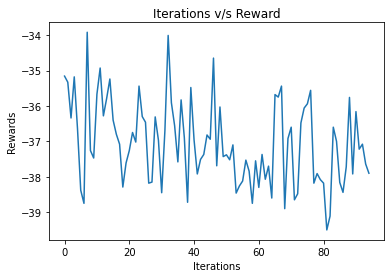

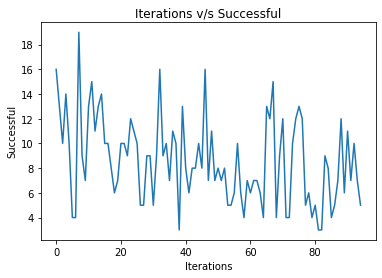

 10%|███████▎                                                                 | 10000/100000 [43:34<7:57:35,  3.14it/s]

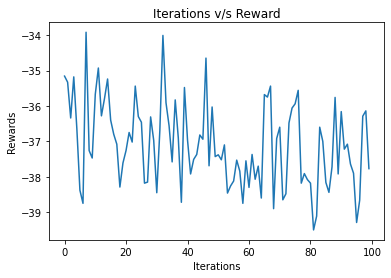

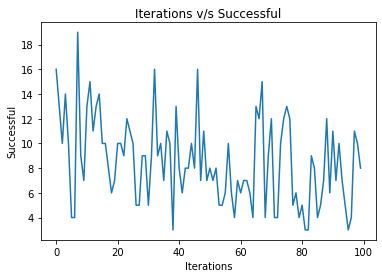

 10%|███████▋                                                                 | 10500/100000 [46:11<8:04:15,  3.08it/s]

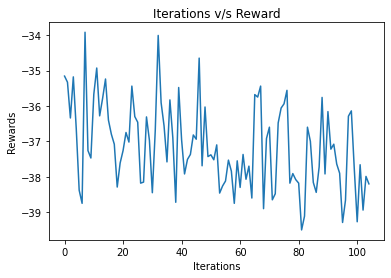

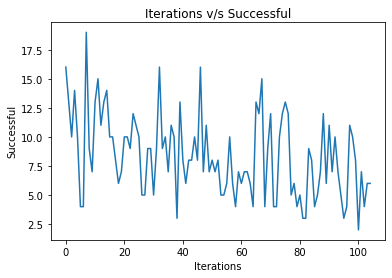

 11%|████████                                                                 | 11000/100000 [48:44<8:32:55,  2.89it/s]

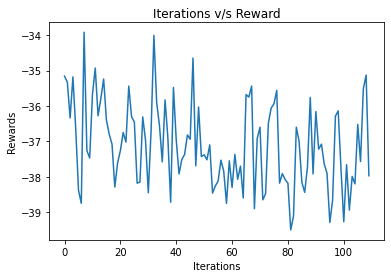

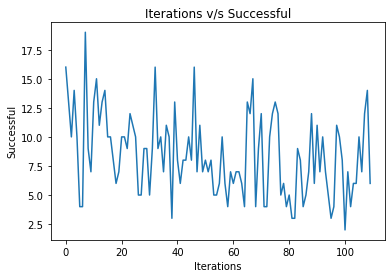

 12%|████████▍                                                                | 11500/100000 [51:20<6:58:23,  3.53it/s]

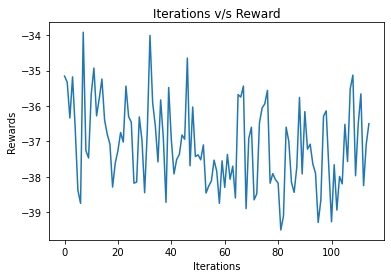

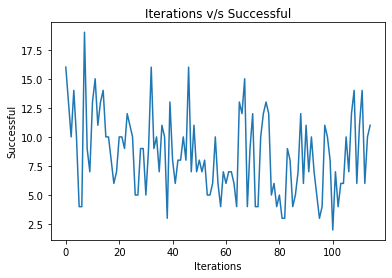

 12%|████████▊                                                                | 12000/100000 [54:01<8:17:36,  2.95it/s]

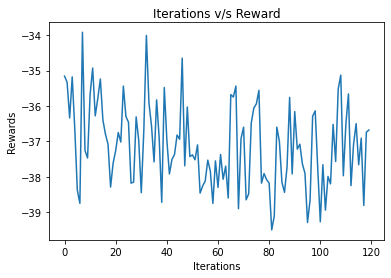

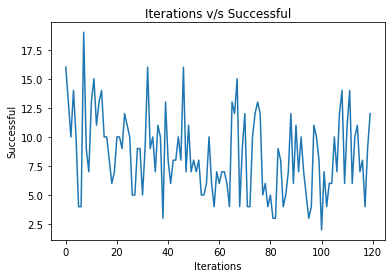

 12%|█████████▏                                                               | 12500/100000 [56:58<9:07:21,  2.66it/s]

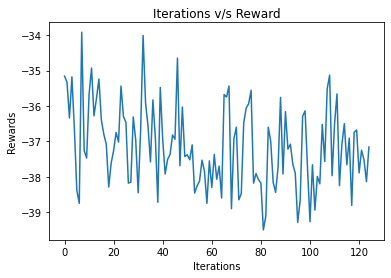

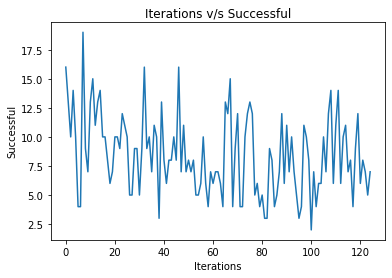

 13%|█████████                                                             | 13000/100000 [1:00:22<10:40:23,  2.26it/s]

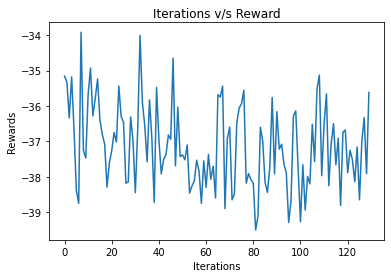

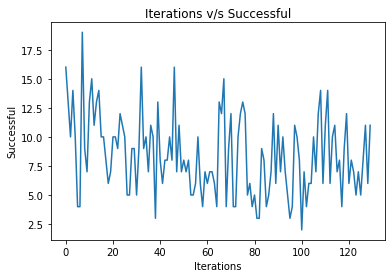

 14%|█████████▍                                                            | 13500/100000 [1:03:47<10:14:57,  2.34it/s]

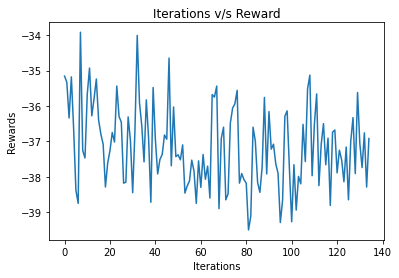

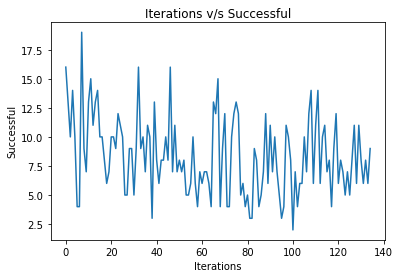

 14%|█████████▉                                                             | 14000/100000 [1:07:13<9:33:27,  2.50it/s]

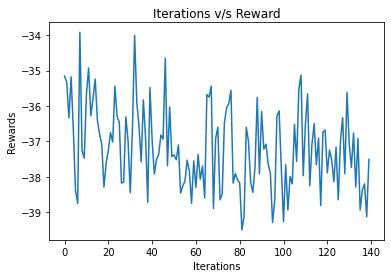

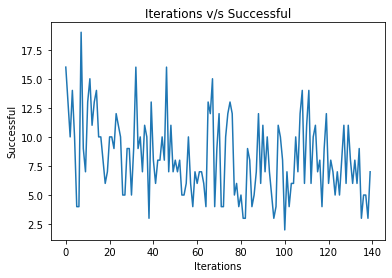

 14%|██████████▏                                                           | 14500/100000 [1:10:39<10:58:38,  2.16it/s]

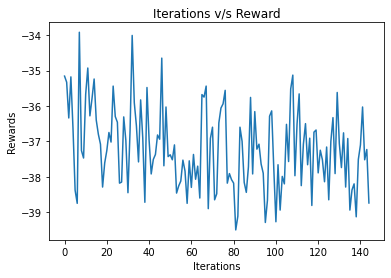

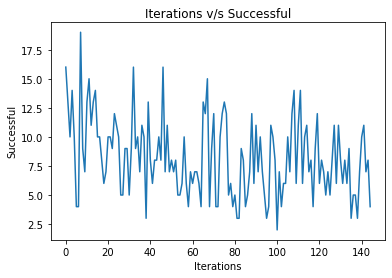

 15%|██████████▍                                                            | 14687/100000 [1:11:56<6:57:54,  3.40it/s]


KeyboardInterrupt: 

In [6]:
rewards = []
mean_rewards = []
max_steps = 40
reached = 0
reached_history = []
max_reached = 0

for epoch in tqdm(range(100000)):
    done = False
    episode_reward = 0
    start, dest = env.give_start_dest()
    ob_user = [start[0], start[1], dest[0], dest[1]]
    prev_steps_assist = []
    prev_steps_assist = give_prev_steps(prev_steps_assist, steps)
    step = 0
    
    while not done and step<max_steps:
        ob_user, prev_steps_assist, reward_user, reward_assist, done = model.step(ob_user, prev_steps_assist)
        episode_reward+=reward_user
        step+=1
        if done:
            reached+=1
            
    rewards.append(episode_reward)
    
    if epoch>50:
        model.train()
        
        if epoch%100==0:
            model.target_user_model.set_weights(model.user_model.get_weights())
            model.target_assist_model.set_weights(model.assist_model.get_weights())
            
            mean_rewards.append(np.mean(rewards))
            reached_history.append(reached)
            rewards = []
            
            if reached>max_reached:
                print(reached)
                print('Saved Weights')
                max_reached = reached
                model.user_model.save('user_model.h5')
                model.assist_model.save('assist_model.h5')
                
            reached = 0
            
            if epoch%500==0:
                plt.plot(mean_rewards)
                plt.xlabel('Iterations')
                plt.ylabel('Rewards')
                plt.title('Iterations v/s Reward')
                plt.show()
            
                plt.plot(reached_history)
                plt.xlabel('Iterations')
                plt.ylabel('Successful')
                plt.title('Iterations v/s Successful')
                plt.show()
                
                if epoch%2500==0:
                    model.epsilon*=0.95
                    model.epsilon= max(model.epsilon, 0.1)
                    
                    if epoch%20000==0:
                        model.infer()